In [7]:
import sys
sys.path.append('Libraries/')
import pclpy
import cv2
import imp
import glob
import os
import numpy as np
import pcl
import open3d
import pdal
from Plane import tic,toc
import segTree
import pandas as pd

from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import CameraStuff

In [9]:
PartColumns = "n_ref,n_match,n_extr,Completeness,Correctness,Diameter_RMSE,Location_RMSE,Relative_Diameter_RMSE,Relative_Location_RMSE"

test = 1
if test==1:
    fileFGI = np.load('saveTEST.npz')
    columns = "verticalityThresh,NonNANcurvatureThresh,lowstems_Height,cutstems_Height,n_ref,n_match,n_extr,Completeness,Correctness,Diameter_RMSE,Location_RMSE,Relative_Diameter_RMSE,Relative_Location_RMSE"
elif test==2:
    fileFGI = np.load('saveTESTstrieghtnessThresh.npz')
    columns = "verticalityThresh,NonNANcurvatureThresh,lowstems_Height,cutstems_Height,n_ref,n_match,n_extr,Completeness,Correctness,Diameter_RMSE,Location_RMSE,Relative_Diameter_RMSE,Relative_Location_RMSE,strieghtnessThresh"
    

In [10]:
fileFGI.allow_pickle=True

In [11]:
ALLDATA = []
for i in fileFGI['Register']:
    single_data = {}
    for n,k in enumerate(columns.split(',')):
        single_data[k] = i[n]
    ALLDATA.append(single_data)

In [12]:
ALLDATA_BYCAT = {}
for n,k in enumerate(PartColumns.split(',')):    
    easy = ALLDATA[0][k][0:2]
    medium = ALLDATA[0][k][2:4]
    hard = ALLDATA[0][k][4:6]
    for i in ALLDATA[1:]:
        easy = easy + i[k][0:2]
        medium = medium + i[k][2:4]
        hard = hard + i[k][4:6]
    ALLDATA_BYCAT[k] = easy+medium+hard

In [13]:
ALLDATA_BYCAT1 = {}
ALLDATA_BYCAT2 = {}
for n,k in enumerate(PartColumns.split(',')):    
    easy1 = [ALLDATA[0][k][0]]
    medium1 = [ALLDATA[0][k][2]]
    hard1 = [ALLDATA[0][k][4]]
    easy2 = [ALLDATA[0][k][2-1]]
    medium2 = [ALLDATA[0][k][4-1]]
    hard2 = [ALLDATA[0][k][6-1]]
    for i in ALLDATA[1:]:
        easy1 = easy1 + [i[k][0]]
        medium1 = medium1 + [i[k][2]]
        hard1 = hard1 + [i[k][4]]
        easy2 = easy2 + [i[k][1]]
        medium2 = medium2 + [i[k][3]]
        hard2 = hard2 + [i[k][5]]
    ALLDATA_BYCAT1[k] = easy1 + medium1 + hard1
    ALLDATA_BYCAT2[k] = easy2 + medium2 + hard2

In [14]:
if test==1:
    Vertplot = np.array([i['verticalityThresh'] for i in ALLDATA])
    newVertplot = []
    for i in range(3):
        newVertplot = newVertplot + (Vertplot*2).tolist()

    Curplot = np.array([i['NonNANcurvatureThresh'] for i in ALLDATA])
    newCurplot = []
    for i in range(3):
        newCurplot = newCurplot + (Curplot*2).tolist()

    print(Vertplot)
    print(Curplot)
elif test==2:
    Strplot = np.array([i['strieghtnessThresh'] for i in ALLDATA])
    newVertplot = []
    for i in range(3):
        newVertplot = newVertplot + (Strplot/2).tolist()
    ar1 = len(Strplot)
    ar2 = 1

[0.04 0.04 0.04 0.04 0.04 0.04 0.06 0.06 0.06 0.06 0.06 0.06 0.08 0.08
 0.08 0.08 0.08 0.08 0.1  0.1  0.1  0.1  0.1  0.1  0.12 0.12 0.12 0.12
 0.12 0.12 0.14 0.14 0.14 0.14 0.14 0.14]
[0.04 0.06 0.08 0.1  0.12 0.14 0.04 0.06 0.08 0.1  0.12 0.14 0.04 0.06
 0.08 0.1  0.12 0.14 0.04 0.06 0.08 0.1  0.12 0.14 0.04 0.06 0.08 0.1
 0.12 0.14 0.04 0.06 0.08 0.1  0.12 0.14]


NameError: name 'ar2' is not defined

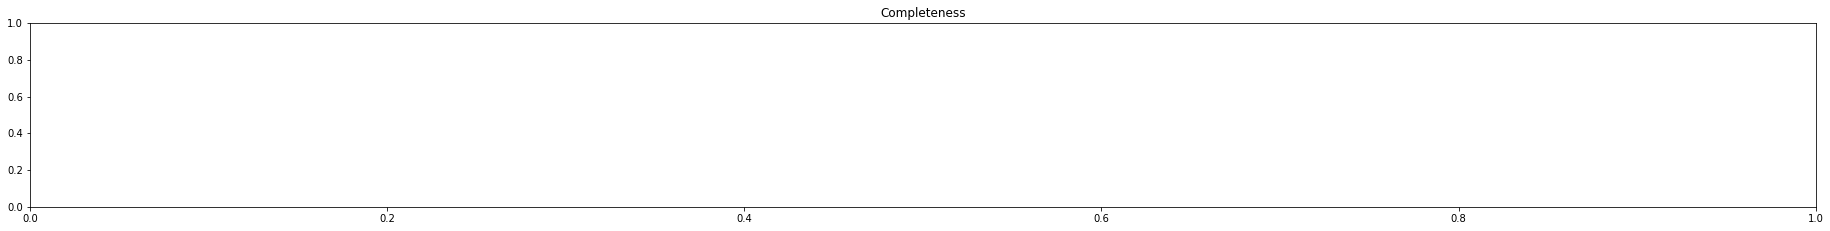

In [15]:
plt.figure(figsize=(32,48))
for n,i in enumerate(PartColumns.split(',')[3:]):
    plt.subplot(12,1,n*2+1)
    plt.title(i)
    ADBCArray = np.array(ALLDATA_BYCAT1[i])
    pos = []
    for j in range(ar2):
        plt.bar(np.arange(ar1*3)*(ar2+1)+j,ADBCArray[np.arange(ar1*3).astype(np.int)*ar2+j])
        pos = pos + (np.arange(ar1*3)*(ar2+1)+j).tolist()
    pos.sort()
    plt.plot(pos,newVertplot,color='k')
    plt.legend(['Verticalidad','Curvatura'])
    for q in np.arange(ar1,18*(ar2+1),(ar2+1)):
        plt.axvline(x=q, ymin=0, ymax=1, color='k')
    
    plt.subplot(12,1,n*2+2)
    plt.title(i)
    ADBCArray = np.array(ALLDATA_BYCAT2[i])
    for j in range(ar2):
        plt.bar(np.arange(ar1*3)*(ar2+1)+j,ADBCArray[np.arange(ar1*3).astype(np.int)*ar2+j])
        
    for q in np.arange(ar1,18*(ar2+1),(ar2+1)):
        plt.axvline(x=q, ymin=0, ymax=1, color='k')
    plt.plot(pos,newVertplot,color='k')
    plt.legend(['Verticalidad','Curvatura'])

Load cloud

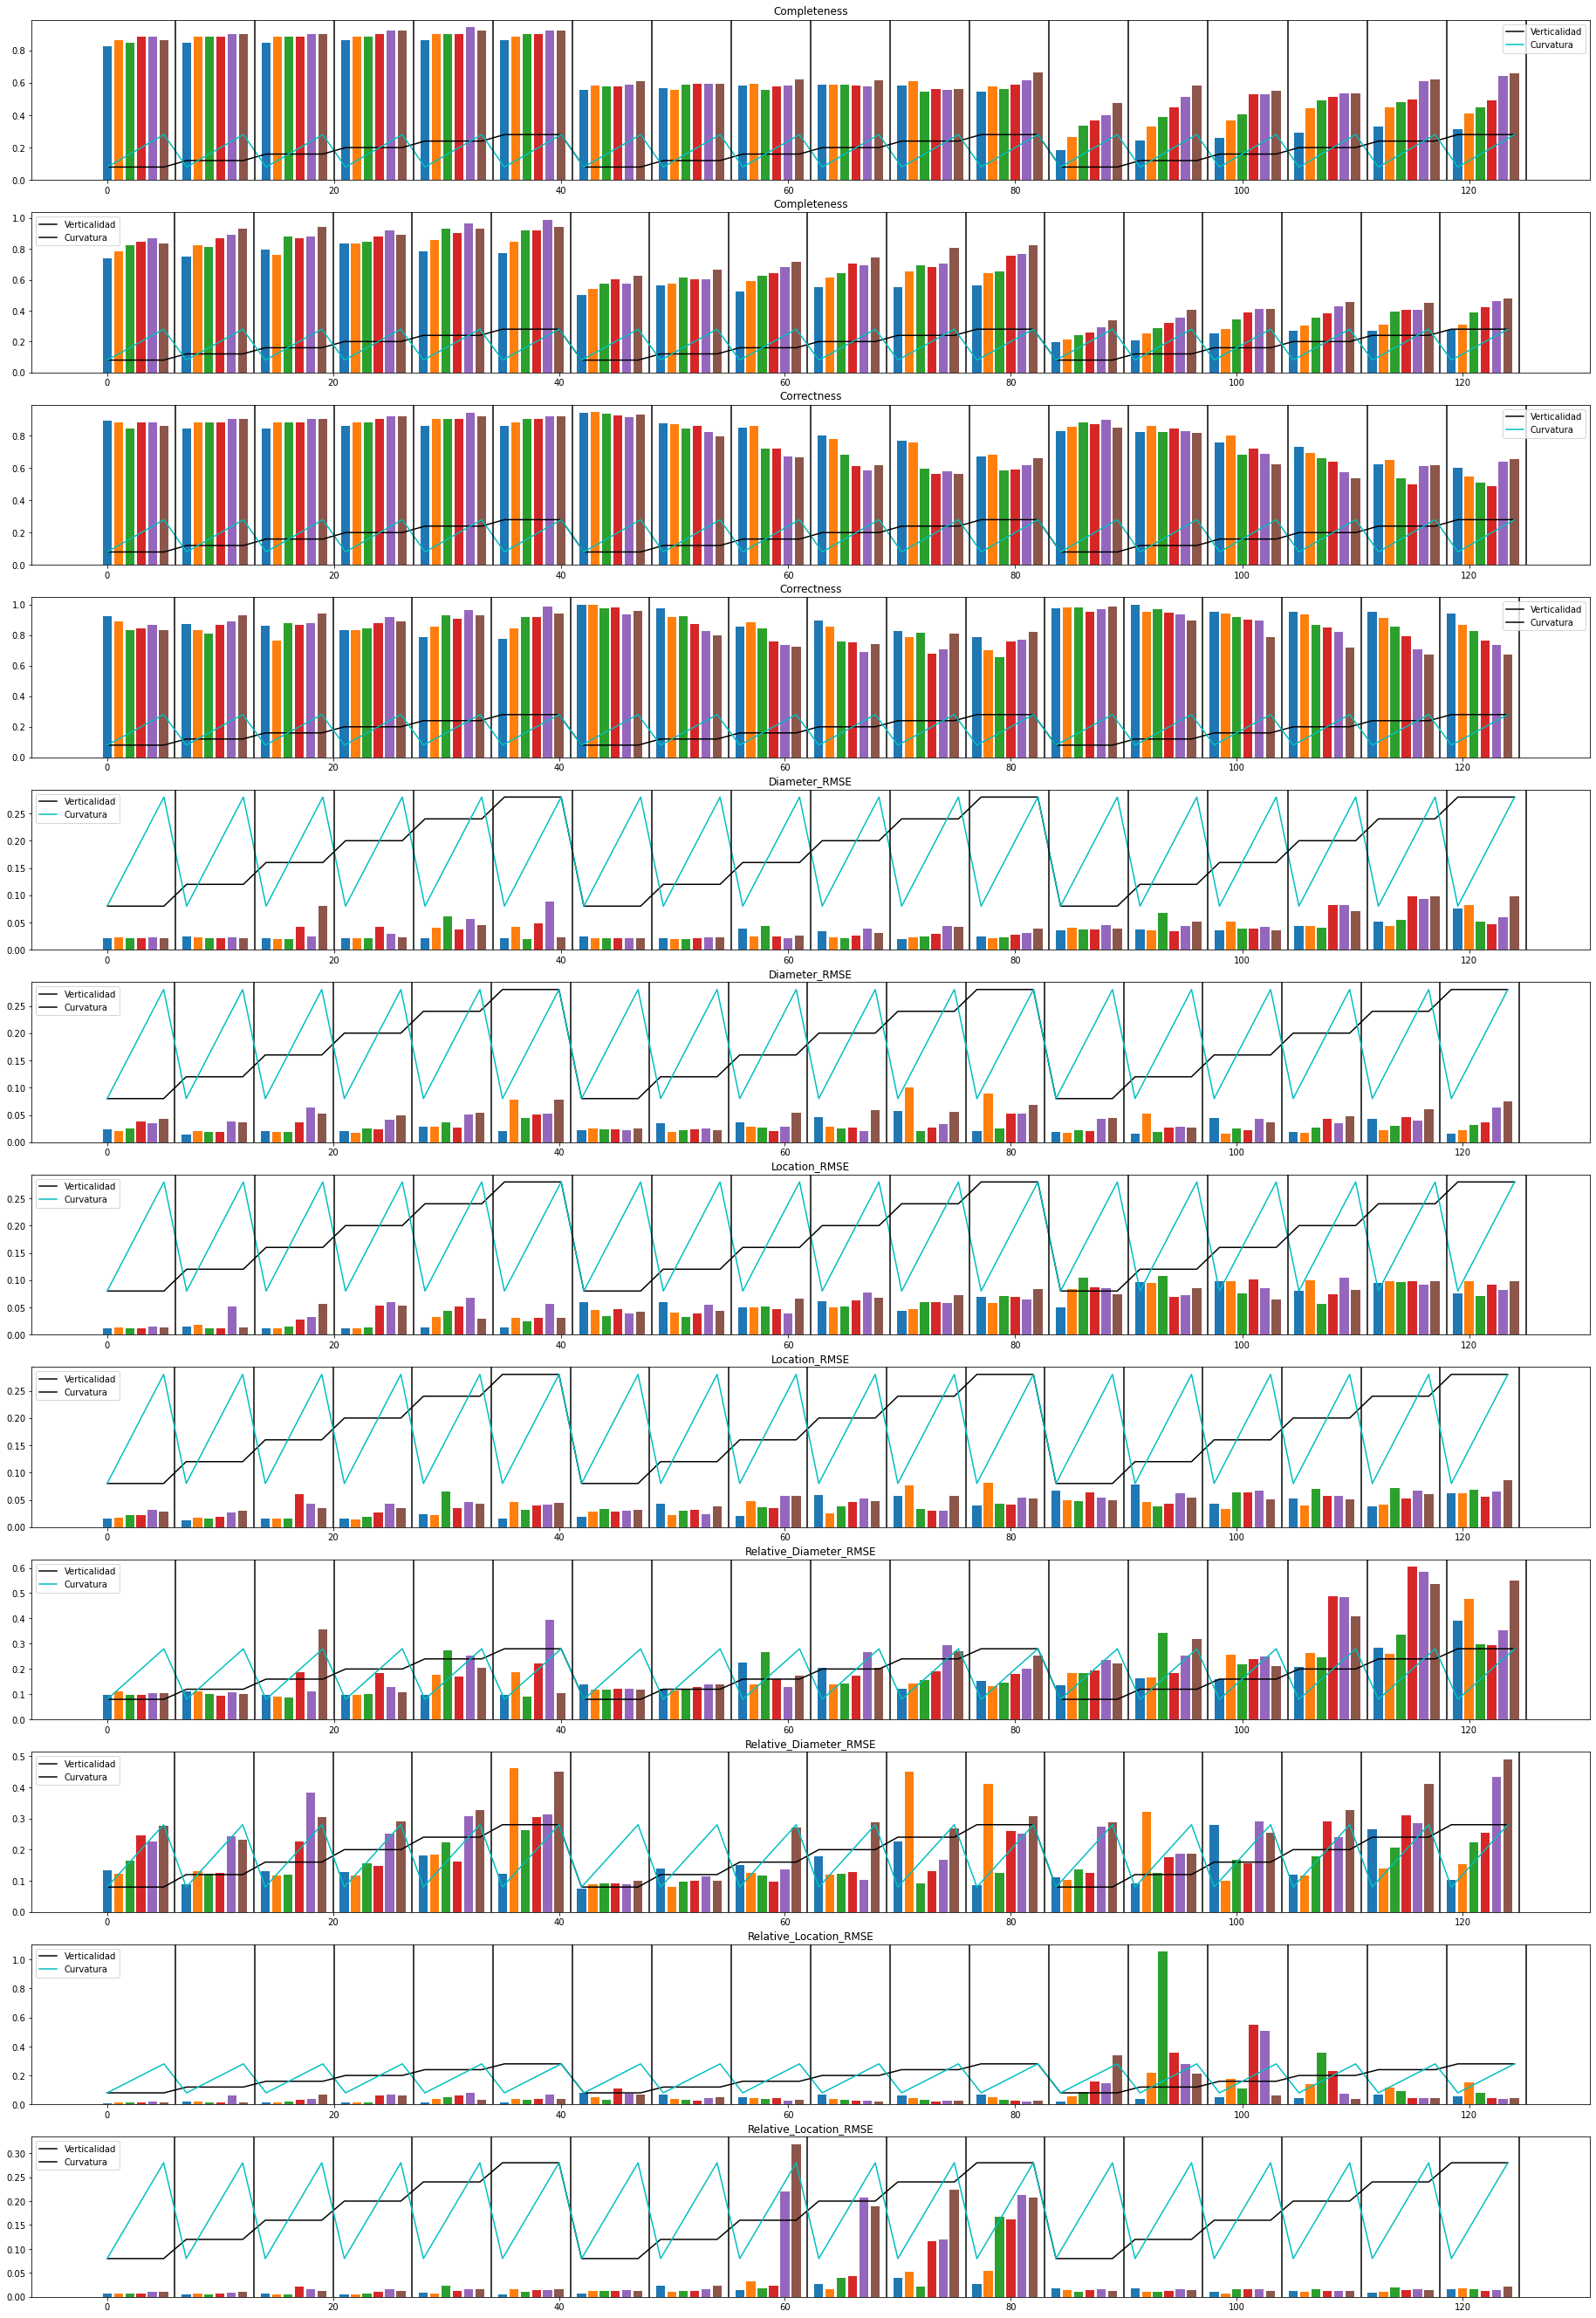

In [17]:
plt.figure(figsize=(32,48))
for n,i in enumerate(PartColumns.split(',')[3:]):
    plt.subplot(12,1,n*2+1)
    plt.title(i)
    ADBCArray = np.array(ALLDATA_BYCAT1[i])
    pos = []
    for j in range(6):
        plt.bar(np.arange(6*3)*7+j,ADBCArray[np.arange(6*3)*6+j])
        pos = pos + (np.arange(6*3)*7+j).tolist()
    pos.sort()
    plt.plot(pos,newVertplot,color='k')
    plt.plot(pos,newCurplot,color='c')
    plt.legend(['Verticalidad','Curvatura'])
    for q in np.arange(6,18*7,7):
        plt.axvline(x=q, ymin=0, ymax=1, color='k')
    
    plt.subplot(12,1,n*2+2)
    plt.title(i)
    ADBCArray = np.array(ALLDATA_BYCAT2[i])
    for j in range(6):
        plt.bar(np.arange(6*3)*7+j,ADBCArray[np.arange(6*3)*6+j])
        
    for q in np.arange(6,18*7,7):
        plt.axvline(x=q, ymin=0, ymax=1, color='k')
    plt.plot(pos,newVertplot,color='k')
    plt.plot(pos,newCurplot,color='c')
    plt.legend(['Verticalidad','Curvatura'])

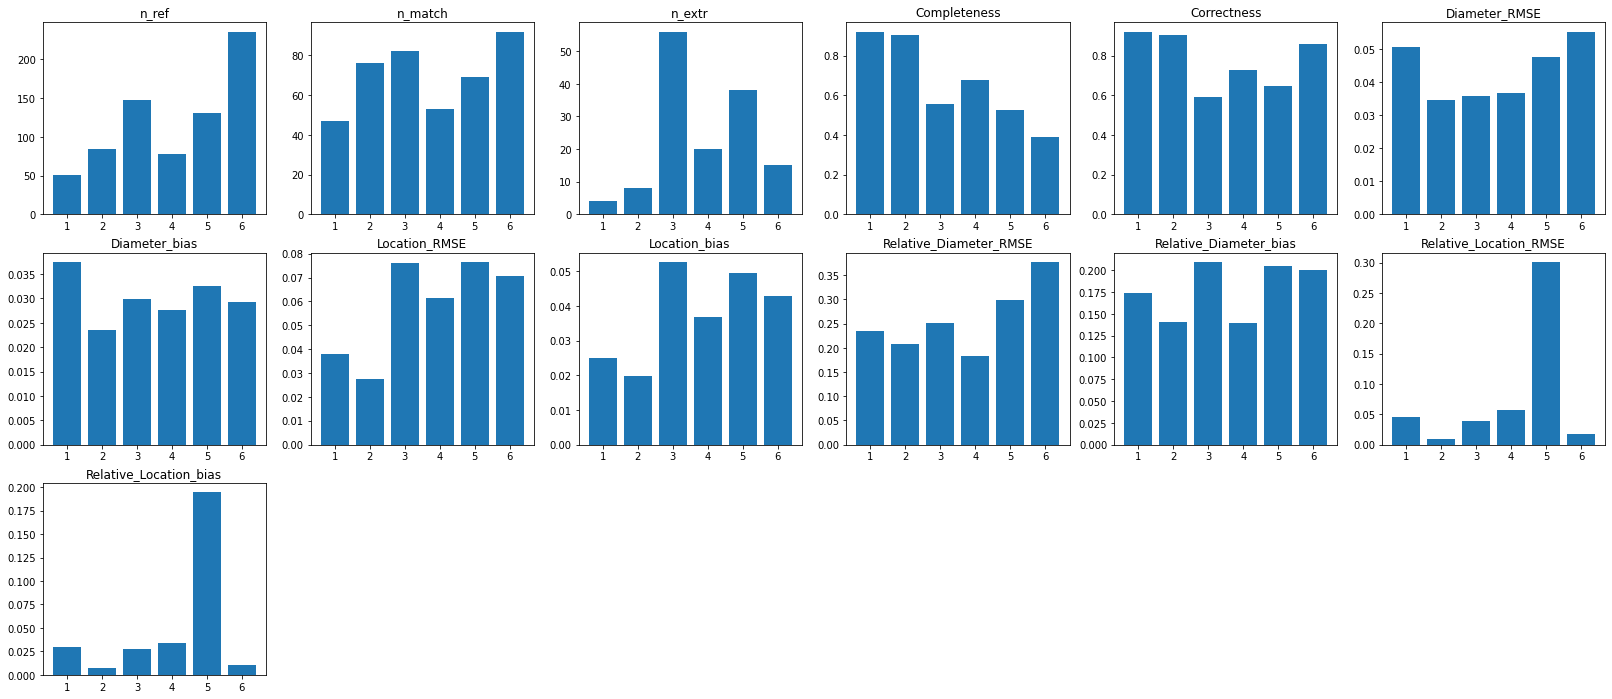

In [5]:
alldata = ['n_ref', 'n_match', 'n_extr', 'Completeness', 'Correctness', 'Diameter_RMSE', 'Diameter_bias', 
           'Location_RMSE', 'Location_bias', 'Relative_Diameter_RMSE', 'Relative_Diameter_bias', 'Relative_Location_RMSE', 'Relative_Location_bias']
plt.figure(figsize=(28,12))
for n,i in enumerate(alldata):
    plt.subplot(3,6,n+1)
    plt.title(i)
    plt.bar(np.array([1,2,3,4,5,6]),eval(i))

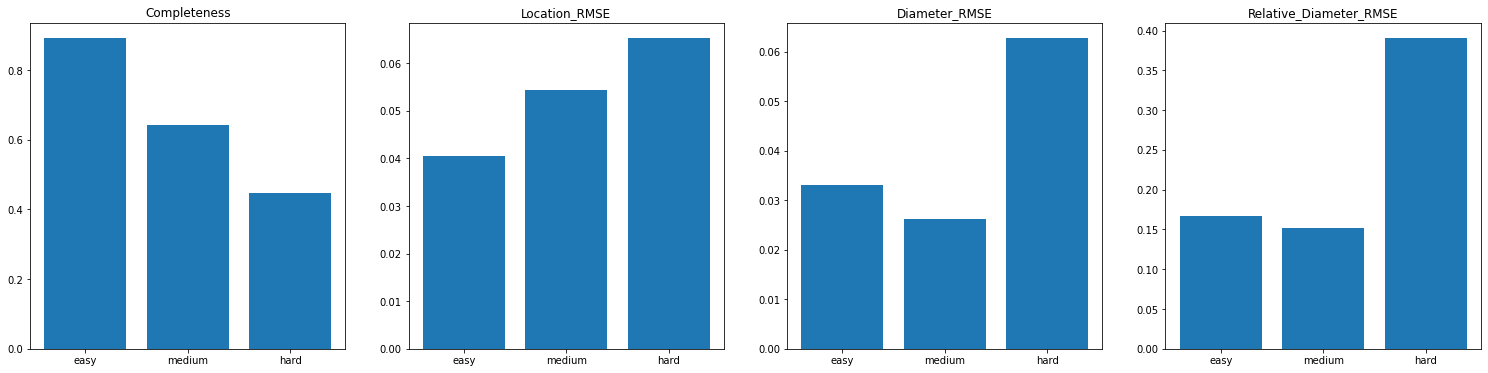

In [39]:
alldata = ['Completeness', 'Location_RMSE', 'Diameter_RMSE', 'Relative_Diameter_RMSE',]
plt.figure(figsize=(26,6))
for n,i in enumerate(alldata):
    plt.subplot(1,4,n+1)
    plt.title(i)
    avdat = [np.mean(eval(i)[slice(k,k+2)]) for k in [0,2,4]]
    plt.bar(np.array(['easy','medium','hard']),avdat)

In [40]:
fileFGI = np.load('resultsFGI.npz')
file = np.load('results.npz')

In [41]:
data = {}
dataFGI = {}
for i in alldata:
    data[i] = file[i]
    dataFGI[i] = fileFGI[i]

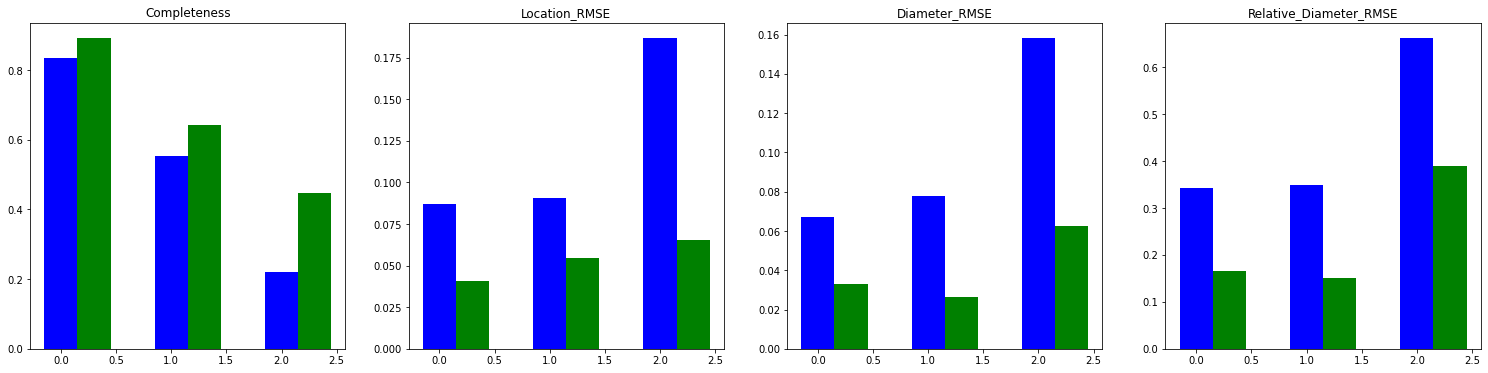

In [42]:
alldata = ['Completeness', 'Location_RMSE', 'Diameter_RMSE', 'Relative_Diameter_RMSE',]
plt.figure(figsize=(26,6))
FIG = {}
FIG = [90,87.5,65]
FIG = [0.025,0.025,0.06]
FIG = [0.025,0.025,0.025]
FIG = [0.025,0.025,0.06]
for n,i in enumerate(alldata):
    plt.subplot(1,4,n+1)
    plt.title(i)
    avdat = [np.mean(data[i][slice(k,k+2)]) for k in [0,2,4]]
    avdatFGI = [np.mean(dataFGI[i][slice(k,k+2)]) for k in [0,2,4]]
    #plt.bar(np.array(['easy','medium','hard']),avdat)
    plt.bar([0,1,2],avdat,width=0.3, color='b', align='center')
    plt.bar([0.3,1.3,2.3],avdatFGI,width=0.3, color='G', align='center')
    #plt.bar(np.array(['easy','medium','hard']),avdatFGI)